In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
# CORPUS_DIR = "convokit/thread_generator/fake-corpus-trajectory"
# CORPUS_DIR = "convokit/thread_generator/annotated-fake-trajectory"
CORPUS_DIR = "convokit/tensor_decomposer/experiments/reddit-trajectory-subset"

In [4]:
from convokit import TensorDecomposer, HyperConvo, Corpus

In [5]:
corpus = Corpus(filename=CORPUS_DIR)

In [6]:
corpus.random_conversation().meta['hyperconvo-20']

KeyError: 'hyperconvo-20'

In [7]:
hyperconv_range = range(2, 20+1)

In [7]:
hyperconv_range = range(2, 20+1)
def multi_hyperconv_transform(corpus, hyperconv_range):
    hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i)) for i in hyperconv_range]
    for idx, hc in enumerate(list(reversed(hc_transformers))):
        print(hyperconv_range[-1]-idx)
        hc.transform(corpus)

In [8]:
multi_hyperconv_transform(corpus, hyperconv_range)

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2


In [9]:
corpus.dump("reddit-trajectory-subset-annotated", base_path="convokit/tensor_decomposer/experiments")

In [10]:
import numpy as np
def _min_max_scale(mat):
    max_ = np.max(mat)
    min_ = np.min(mat)
    return (mat - min_) / (max_ - min_)

def minmax_normalize(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = _min_max_scale(tensor[:, :, i])
    return tensor

In [11]:
hyperconv_range = range(2, 20+1)
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [12]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [13]:
# td.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_normal', 
#              report_title="25 May (normal)")

In [13]:
score = td.purity(n_clusters=3, actual_num_clusters=3, group_size=500)
print(score)

0.8093333333333333


## Standard (from 3)

In [14]:
td_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 20+1)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [15]:
td_3.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [16]:
td_3.tensor.shape

(18, 1500, 140)

In [17]:
score = td_3.purity(n_clusters=3, actual_num_clusters=3, group_size=500)
print(score)

0.81


## Min-max normalized (across threads)

### From 2

In [18]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )

In [19]:
td_min_max.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


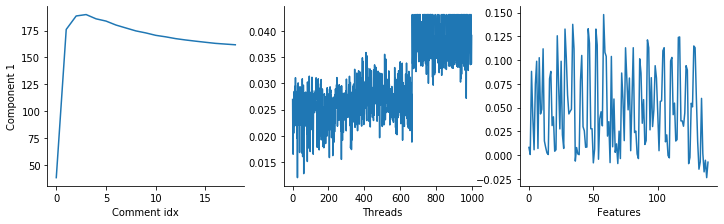

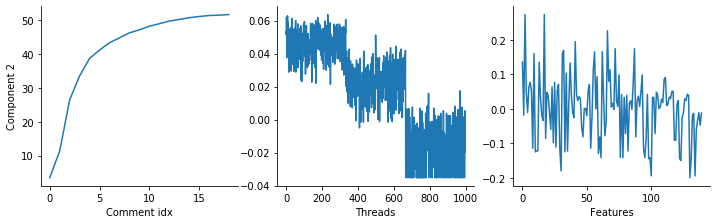

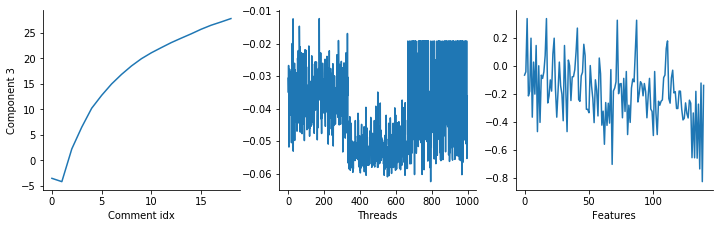

In [21]:
# td_min_max.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_minmax', 
#              report_title="25 May (min_max)")

In [20]:
score = td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=500)
print(score)

0.9273333333333333


### From 3

In [22]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )
td_min_max.fit(corpus)
td_min_max.purity(n_clusters=3, actual_num_clusters=3, group_size=500)

Constructing tensor...Done.
Decomposing tensor...Done.


0.9273333333333333

## Standard-scaled (across threads)

In [23]:
from sklearn.preprocessing import StandardScaler
def standard_scale(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = StandardScaler().fit_transform(tensor[:, :, i])
    return tensor

### From 2

In [24]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )

In [25]:
td_std_scale.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


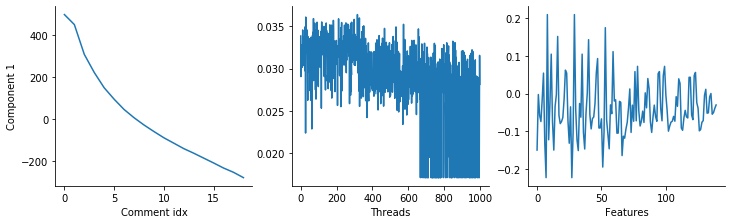

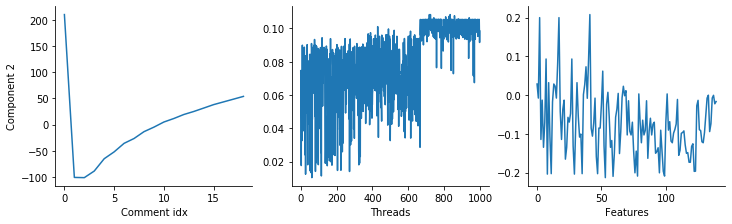

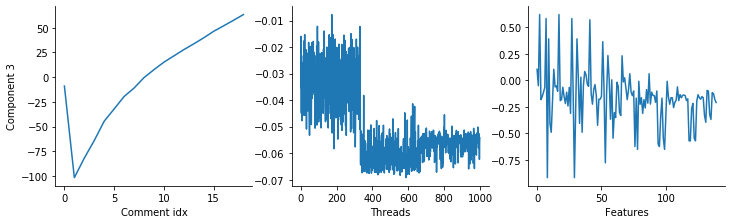

In [27]:
# td_std_scale.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
#              output_dir='convokit/tensor_decomposer/reports/25May_std_scl', 
#              report_title="25 May (std scale)")

In [27]:
score = td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=500)
print(score)

0.6806666666666666


### From 3

In [29]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )
td_std_scale.fit(corpus)
td_std_scale.purity(n_clusters=3, actual_num_clusters=3, group_size=500)

Constructing tensor...Done.
Decomposing tensor...Done.


0.778

## Min-max scaled (within thread)

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
def _min_max_within(mat):
    mms = MinMaxScaler()
    for i in range(mat.shape[1]):
        min_ = np.min(mat[:, i])
        max_ = np.max(mat[:, i])
        if max_ - min_ == 0:
            mat[:, i] = 0
        else:
            mat[:, i] = (mat[:, i] - min_)/ (max_ - min_)
    return mat

def minmax_within(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[1]):
        tensor[:, i, :] = _min_max_within(tensor[:, i, :])
    return tensor

## From 2

In [32]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [33]:
td_min_max_within.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


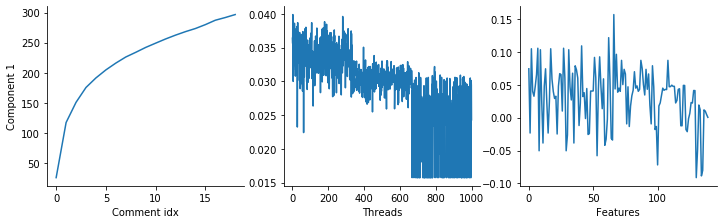

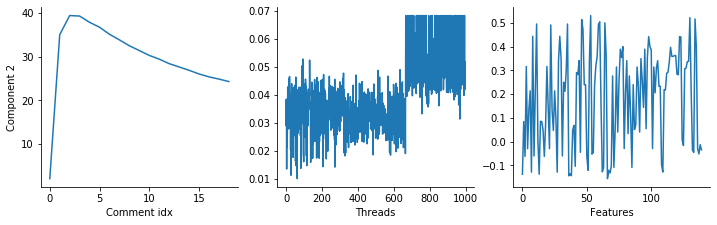

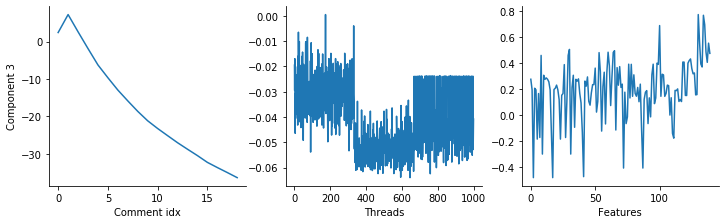

In [33]:
td_min_max_within.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_minmax_within', 
             report_title="25 May (min max within)")

In [34]:
score = td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=500)
print(score)

0.7926666666666666


### From 3

In [35]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [36]:
td_min_max_within.fit(corpus)
td_min_max_within.purity(n_clusters=3, actual_num_clusters=3, group_size=500)

Constructing tensor...Done.
Decomposing tensor...Done.


0.6593333333333333